In [ ]:
!pip3 install python-chess

In [ ]:
import pandas as pd
import ast
from collections import defaultdict as dd
import regex as re
import seaborn as sns
import numpy as np
import chess
from itertools import chain


# Descriptive Analytics

In [86]:
df = pd.read_csv("sample.csv", header=0, index_col = 0)

In [87]:
df.head()

,Event,Site,GameNumber,WName,BName,WElo,BElo,WRD,BRD,WIsComp,...,TimeControl,Date,Time,WClock,BClock,ECO,PlyCount,Result,WMoves,BMoves
0,FICS rated blitz game,FICS freechess.org,470452425,chesspickle,lawrencegern,1963,764,21.2,112.200,Yes,...,300+0,2020.01.31,23:54:00,05:00.0,05:00.0,D11,43,1-0,"['d4', 'c4', 'Nf3', 'e3', 'Bxc4', 'Be2', 'Bd2'...","['d5', 'c6', 'dxc4', 'e6', 'b5', 'Bb4+', 'Bxd2..."
1,FICS rated blitz game,FICS freechess.org,470452424,ZoneBlindTal,AhNeow,1600,1487,36.6,28.500,NaN,...,180+2,2020.01.31,23:52:00,03:00.0,03:00.0,C41,48,0-1,"['e4', 'Nf3', 'd4', 'dxe5', 'Nc3', 'Nd5', 'Bd2...","['e5', 'd6', 'Qe7', 'dxe5', 'f6', 'Qd6', 'c6',..."
2,FICS rated blitz game,FICS freechess.org,470452423,forlat,naraindra,1948,1089,15.3,30.700,Yes,...,300+0,2020.01.31,23:54:00,05:00.0,05:00.0,D00,67,1-0,"['d4', 'g3', 'Bg2', 'Nf3', 'O-O', 'e3', 'c3', ...","['d5', 'b5', 'Bb7', 'h6', 'e6', 'Bd6', 'Nf6', ..."
3,FICS rated blitz game,FICS freechess.org,470452420,PGierech,kkpsA,1497,1224,32.4,37.600,NaN,...,120+12,2020.01.31,23:55:00,02:00.0,02:00.0,D00,23,1-0,"['e4', 'd4', 'dxe5', 'exd5', 'Nf3', 'Be2', 'Bx...","['d5', 'e5', 'Nc6', 'Nxe5', 'Bg4', 'Nxf3+', 'B..."
4,FICS rated blitz game,FICS freechess.org,470452419,Liszt,Sotavaunu,1594,1554,26.8,34.900,NaN,...,300+2,2020.01.31,23:48:00,05:00.0,05:00.0,B06,53,0-1,"['e4', 'd4', 'f4', 'c3', 'cxd4', 'e5', 'Nc3', ...","['g6', 'Bg7', 'c5', 'cxd4', 'd5', 'Nc6', 'Nh6'..."


In [88]:
df["BMoves"] = df["BMoves"].apply(ast.literal_eval)
df["WMoves"] = df["WMoves"].apply(ast.literal_eval)

In [89]:
df = df[df["WMoves"] != "eow"]
df = df[df["BMoves"] != "eow"]

In [ ]:
df.loc[2,'WMoves']

## Most popular square?

In [ ]:
lookups = [
    ("^.*[a-h][1-8].*$", "normal move"),
    ("^O-O$", "kingside castle"),
    ("^O-O-O$", "queenside castle"),
    ("^.+[QNBR]\+*#*$", "pawn conversion"),
    ("^.*\+$", "check"),
    ("^.*#$", "checkmate")
]

def is_not_castle(move):
    return not bool(re.search("O-O",move))


In [ ]:
square_dict = dd(int)

def count_squares(moves, colour):
    for move in moves:
        if is_not_castle(move):
            square_dict[re.findall("[a-h][1-8]",move)[-1]] += 1
        else:
            if re.search("^O-O$", move):
                if colour=="W":
                    square_dict["g1"] += 1
                else:
                    square_dict["g8"] += 1
            else: 
                if colour=="W":
                    square_dict["c1"] += 1
                else:
                    square_dict["c8"] += 1
    return


In [ ]:
df["BMoves"].apply(lambda x : count_squares(x,'B'))
df["WMoves"].apply(lambda x : count_squares(x,'W'))

## How many moves until a game becomes unique?

In [ ]:
df.loc[195]

In [ ]:
sample_df = df.head(1000)

In [ ]:
moves_until_unique = dd(int)

for i in range(len(sample_df["WMoves"])):
    for j in range(i,len(sample_df["WMoves"])):
        move_count = -1
        g1move = ""
        g2move = ""
        while g1move==g2move:
            move_count += 1
            try:
                if move_count%2 == 0:
                    #White's move
                    g1move = df["WMoves"][i][move_count//2]
                    g2move = df["WMoves"][j][move_count//2]
                else:
                    #Black's move
                    g1move = df["BMoves"][i][move_count//2]
                    g2move = df["BMoves"][j][move_count//2]
            except:
                #end of game
                g1move = 1
                g2move = 2
        if moves_until_unique[i] < move_count:
            moves_until_unique[i] = move_count
        if moves_until_unique[j] < move_count:
            moves_until_unique[j] = move_count
            

In [ ]:
moves_until_unique

## CapturesByPiece
function takes as argument the pandas dataframe and returns the pandas dataframe with capture count for pair of pieces

In [90]:
def capturesByPiece(df):
    # Dict of dict to store the count of captures made by a piece

    captureCount = dict()
    for attacker in chess.UNICODE_PIECE_SYMBOLS.keys():
        captureCount[attacker] = dict()
        for captured in chess.UNICODE_PIECE_SYMBOLS.keys():
            captureCount[attacker][captured] = 0
    
  
            
    for index, row in df.iterrows():
        WMoves = row["WMoves"]
        BMoves = row["BMoves"]

        board = chess.Board()

        # zipping all the moves and merging into one list 
        allMoves = zip(WMoves, BMoves)
        zippedMoves = list(chain.from_iterable(allMoves))

        for move in zippedMoves:
            if board.is_capture(board.parse_san(move)):
                moveInUCI = board.uci(board.parse_san(move))
#                 print("move:",move)
                attackerPosition, capturedPosition = moveInUCI[:2], moveInUCI[2:4]
#                 print("ap,cp:"+attackerPosition, capturedPosition)
                attacker = board.piece_at(chess.SQUARE_NAMES.index(attackerPosition))
                captured = board.piece_at(chess.SQUARE_NAMES.index(capturedPosition))
#                 print("a,c:",attacker,captured)
                
                if (str(attacker) in captureCount.keys()) and (str(captured) in captureCount.keys()):
                    captureCount[str(attacker)][str(captured)] += 1
        
            board.push_san(move)
        
#         print()
    
    capture_count = pd.DataFrame(captureCount)
    capture_count.rename(columns = chess.UNICODE_PIECE_SYMBOLS, index =  chess.UNICODE_PIECE_SYMBOLS, inplace = True) 

    return  capture_count

CPU times: user 2min 33s, sys: 100 ms, total: 2min 33s
Wall time: 2min 33s


<AxesSubplot:>

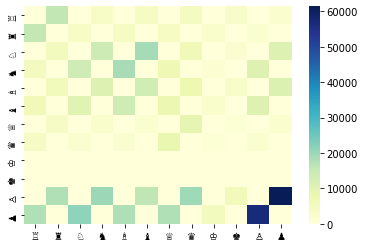

In [92]:
%%time
sns.heatmap(capturesByPiece(df), cmap="YlGnBu")

# Prescriptive Analytics

## Feature Engineering

## Add columns for who won game

In [ ]:
def get_player_result(result, colour):
    if colour=='B':
        if result[-1]=='0':
            return 0
        else:
            return 1
    else:
        if result[0]=='0':
            return 0
        else:
            return 1

def add_WL_columns(df):
    df['WResult'] = df["Result"].apply(lambda x: get_player_result(x, 'W'))
    df['BResult'] = df["Result"].apply(lambda x: get_player_result(x, 'B'))
    return

In [ ]:
add_WL_columns(df)

## Add columns for pawn conversions

In [ ]:
def get_conversions(moves):
    conversions = []
    for move in moves:
        if re.match(lookups[3][0], move) is not None:
            conversions.append(re.search("(?<=[a-h][1-8]=)[QNBR]",move).group(0))
    return len(conversions)

def add_conversions_columns(df):
    df["WConversions"] = df["WMoves"].apply(lambda x: get_conversions(x))
    df["BConversions"] = df["BMoves"].apply(lambda x: get_conversions(x))

In [ ]:
add_conversions_columns(df)

**Add columns for what piece was used the most by a player**

In [ ]:
df['WFavPiece'] = 'null'
df['BFavPiece'] = 'null'

WPieceMoves = {'N': 0, 'B': 0, 'R': 0, 'Q': 0, 'K':0}
BPieceMoves = {'N': 0, 'B': 0, 'R': 0, 'Q': 0, 'K':0}

def get_favPiece():
    for i in range(len(df)):
        moves = df.loc[i, 'WMoves']
        for move in moves:
            if(move):
                if move[0].isupper() and move[0] != 'O':
                    WPieceMoves[move[0]] += 1
        FavPiece = max(WPieceMoves, key=WPieceMoves.get)
        df.loc[i, ['WFavPiece']] = FavPiece
        
        moves = df.loc[i, 'BMoves']
        for move in moves:
            if(move):
                if move[0].isupper() and move[0] != 'O':
                    BPieceMoves[move[0]] += 1
        FavPiece = max(BPieceMoves, key=BPieceMoves.get)
        df.loc[i, ['BFavPiece']] = FavPiece

In [ ]:
get_favPiece()

## Moves Count
Moves can either be ordinary move or capturing move, 
 - `WCaptureMovesCount` represent number of capturing moves in the game made by White player
 - `BCaptureMovesCount` represent number of capturing moves in the game made by Black player
 - `WOrdMovesCount` represent number of ordinary moves in the game made by White player
 - `BOrdMovesCount` represent number of oridnary moves in the game made by Black player

In [ ]:
def captureCount(moves):
    count = 0
    for move in moves:
        if "x" in move:
            count += 1
    return count
            

In [ ]:
def ordinaryCount(moves):
    count = 0
    for move in moves:
        if "x" not in move:
            count += 1
    return count

In [ ]:
def addmovesCount():
    df["WCaptureMovesCount"] = df["WMoves"].apply(captureCount)
    df["BCaptureMovesCount"] = df["BMoves"].apply(captureCount)

    df["WOrdMovesCount"] = df["WMoves"].apply(ordinaryCount)

    df["BOrdMovesCount"] = df["BMoves"].apply(ordinaryCount)

In [ ]:
addmovesCount()

## Number of pieces at the end of the game

In [ ]:
def addpieces():
    df["WPiecesCount"] = np.abs(df["BCaptureMovesCount"].subtract(16))

    df["BPiecesCount"] = np.abs(df["WCaptureMovesCount"].subtract(16))

In [ ]:
addpieces()

## Pairwise capture count
    - Uppercase letter(R,N,B,Q,K,P) represent White pieces 
    - lowercase letter(r,n,b,q,k,p) represent Black pieces
    - Column "Pp" represent P captures p count

In [ ]:
def pairCaptureDict(WMoves, BMoves):
#     Dictionary to store count
    captureCount = dict()
    for attacker in chess.UNICODE_PIECE_SYMBOLS.keys():
        for captured in chess.UNICODE_PIECE_SYMBOLS.keys():
            key = attacker+captured
            if (not key.isupper()) and (not key.islower()):
                captureCount[key] = 0
                
                
    board = chess.Board()
 # zipping all the moves and merging into one list 
    allMoves = zip(WMoves, BMoves)
    zippedMoves = list(chain.from_iterable(allMoves))

    for move in zippedMoves:
        if board.is_capture(board.parse_san(move)):
            moveInUCI = board.uci(board.parse_san(move))
#                 print("move:",move)
            attackerPosition, capturedPosition = moveInUCI[:2], moveInUCI[2:4]
#                 print("ap,cp:"+attackerPosition, capturedPosition)
            attacker = board.piece_at(chess.SQUARE_NAMES.index(attackerPosition))
            captured = board.piece_at(chess.SQUARE_NAMES.index(capturedPosition))
#                 print("a,c:",attacker,captured)
            key = (str(attacker)+str(captured))
            if (key in captureCount.keys()):
                    captureCount[key] += 1
        board.push_san(move)
    return captureCount


In [ ]:
#  Adds the features to the dataframe 
df['pairCaptureDict'] = df.apply(lambda x: pairCaptureDict(x.WMoves, x.BMoves), axis=1)

new_df = pd.DataFrame(list(df["pairCaptureDict"]))

df = pd.concat([df, new_df], axis=1)

df = df.drop(columns = "pairCaptureDict")

In [ ]:
df.head()

## finding first check

In [ ]:
def find_check(entry):
    n_moves = 0;
    for i in range(len(entry["WMoves"])):
        n_moves+=1
        if entry["WMoves"][i][-1] == "+":
            return n_moves
        if i == len(entry["WMoves"]) - 1 and len(entry["WMoves"]) != len(entry["BMoves"]):
            return -1
        if entry["BMoves"][i][-1] == "+":
            return n_moves
    return -1

def find_checks(df):
    chks = []
    for i in range(len(df)):
        chks.append(find_check(df.iloc[i]))
    df["first_check"] = chks

In [ ]:
def find_first_check(moves):
    for i in range(len(moves)):
        if moves[i][-1] == "+":
            return i
    return len(moves)

def get_check(moves):
    for i in range(len(moves)):
        if moves[i][-1] == "+":
            return i
    else:
        return 0

def make_check_columns(df):
    df["BCheck"] = df["BMoves"].apply(lambda x: get_check(x))
    df["WCheck"] = df["WMoves"].apply(lambda x: get_check(x))
    df["BChecked"] = df["WMoves"].apply(lambda x: get_check(x))
    df["WChecked"] = df["BMoves"].apply(lambda x: get_check(x))

In [ ]:
make_check_columns(df)

In [ ]:
pd.set_option('display.max_columns', None)

## High skill openings

In [ ]:
def high_skill_openings(df):
    open_elo = dd(int)
    open_count = dd(int)
    bOpens = []
    wOpens = []
    for i in range(len(df)):
        wOpen = tuple(df["WMoves"][i][0:5])
        wOpens.append(wOpen)
        wSkill = df["WElo"][i]
        open_elo[wOpen] += int(wSkill)
        open_count[wOpen] += 1
        bOpen = tuple(df["BMoves"][i][0:5])
        bOpens.append(wOpen)
        bSkill = df["BElo"][i]
        open_elo[bOpen] += bSkill
        open_count[bOpen] += 1
        
    for key in open_elo.keys():
        open_elo[key] = open_elo[key]/open_count[key]
    return open_elo, bOpens, wOpens

def openings(df):
    elos, bOpens, wOpens = high_skill_openings(df)
    df["bOpens"] = bOpens
    df["wOpens"] = wOpens

In [ ]:
openings(df)

In [ ]:
df.head()

**Score Calculation**

In [ ]:
InitialBoardW = ['Pa2', 'Pb2', 'Pc2', 'Pd2', 'Pe2', 'Pf2', 'Pg2', 'Ph2', 'Ra1', 'Nb1', 'Bc1', 'Qd1', 'Ke1', 'Bf1', 'Ng1', 'Rh1']
InitialBoardB = ['Pa7', 'Pb7', 'Pc7', 'Pd7', 'Pe7', 'Pf7', 'Pg7', 'Ph7', 'Ra8', 'Nb8', 'Bc8', 'Qd8', 'Ke8', 'Bf8', 'Ng8', 'Rh8']

PieceVal = {'P': 1, 'N': 3, 'B': 3, 'R': 5, 'Q': 9, 'K':100}

def calculateScore(movesList):
    scoreW = scoreB = 39                                                                                                                           
    for i in range(len(movesList)):
        if 'x' in movesList[i]:       
            posIndex = movesList[i].index('x') + 1
            position = movesList[i][posIndex:]
            j = i-1     
            while j >= 0:
                if position in movesList[j]:
                    if position[0] == movesList[j][0]:
                        if j%2 == 1:
                            scoreB -= 1
                        else:
                            scoreW -= 1
                    elif 'x' in movesList[j]:
                        if movesList[j][0].islower():
                            if j%2 == 1:
                                scoreB -= 1
                            else:
                                scoreW -= 1
                        else:
                            if j%2 == 1:
                                scoreB -= PieceVal[movesList[j][0]]
                            else:
                                scoreW -= PieceVal[movesList[j][0]]
                            
                    else:
                        if j%2 == 1:
                            scoreB -= PieceVal[movesList[j][0]]
                        else:
                            scoreW -= PieceVal[movesList[j][0]]
                j -= 1
                
            if i%2 == 0:
                for piece in InitialBoardB:
                    if position in piece:
                        scoreB -= PieceVal[piece[0]]
            else:
                for piece in InitialBoardW:
                    if position in piece:
                        scoreW -= PieceVal[piece[0]]        
        
    return scoreW, scoreB

In [ ]:
completeList = []
for i in range(len(df)):
    moves = []
    wmoves = df.loc[i,'WMoves']
    bmoves = df.loc[i,'BMoves']
    if len(wmoves) > len(bmoves):
        for k in range(len(bmoves)):
            moves.append(wmoves[k])
            moves.append(bmoves[k])
        #moves.append(wmoves[k+1])
    elif len(wmoves) == len(bmoves):
        for k in range(len(bmoves)):
            moves.append(wmoves[k])
            moves.append(bmoves[k])
    else:
        for k in range(len(wmoves)):
            moves.append(wmoves[k])
            moves.append(bmoves[k])
        moves.append(bmoves[k+1])
    completeList.append(moves)
df['Moves'] = completeList

In [ ]:
wscoreList = []
bscoreList = []
for i in range(len(df)):
    w, b = calculateScore(df.loc[i, 'Moves'])
    wscoreList.append(w)
    bscoreList.append(b)
    
df['WScore'] = wscoreList
df['BScore'] = bscoreList

In [ ]:
df.head(1)

## one hot encoding for `ECO` column

In [ ]:
# Get one hot encoding of columns B
one_hot = pd.get_dummies(df['ECO'])
# Drop column B as it is now encoded
df = df.drop('ECO',axis = 1)
# Join the encoded df
df = df.join(one_hot)

In [ ]:
df.head(1)

In [ ]:
df.to_csv("sample1.csv")

## Train test split

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RANSACRegressor, Perceptron, RidgeCV, SGDRegressor, ElasticNetCV, LarsCV, LassoCV, LassoLarsCV, OrthogonalMatchingPursuitCV, BayesianRidge, ARDRegression, MultiTaskElasticNetCV, PoissonRegressor, TweedieRegressor, GammaRegressor, enet_path
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
# example of correlation feature selection for numerical data
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from matplotlib import pyplot
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

# other imports
import pandas as pd
import ast
from collections import defaultdict as dd
import regex as re
import seaborn as sns
import numpy as np
import chess
from itertools import chain


In [2]:
df = pd.read_csv("sample1.csv")

/home/student.unimelb.edu.au/jmohammed/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (3,6,8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df.head(3)

,Unnamed: 0,Event,Site,GameNumber,WName,BName,WElo,BElo,WRD,BRD,...,E88,E90,E91,E92,E93,E94,E95,E97,E98,E99
0,0,FICS rated blitz game,FICS freechess.org,470452425,chesspickle,lawrencegern,1963,764,21.2,112.2,...,0,0,0,0,0,0,0,0,0,0
1,1,FICS rated blitz game,FICS freechess.org,470452424,ZoneBlindTal,AhNeow,1600,1487,36.6,28.5,...,0,0,0,0,0,0,0,0,0,0
2,2,FICS rated blitz game,FICS freechess.org,470452423,forlat,naraindra,1948,1089,15.3,30.7,...,0,0,0,0,0,0,0,0,0,0


In [4]:
WX = df[["PlyCount","WResult","BResult","WConversions","BConversions","WCaptureMovesCount","BCaptureMovesCount","WOrdMovesCount","BOrdMovesCount","WPiecesCount","BPiecesCount","Rr","Rn","Rb","Rq","Rk","Rp","rR","rN","rB","rQ","rK","rP","Nr","Nn","Nb","Nq","Nk","Np","nR","nN","nB","nQ","nK","nP","Br","Bn","Bb","Bq","Bk","Bp","bR","bN","bB","bQ","bK","bP","Qr","Qn","Qb","Qq","Qk","Qp","qR","qN","qB","qQ","qK","qP","Kr","Kn","Kb","Kq","Kk","Kp","kR","kN","kB","kQ","kK","kP","Pr","Pn","Pb","Pq","Pk","Pp","pR","pN","pB","pQ","pK","pP","BCheck","WCheck","BChecked","WChecked","WScore","BScore","A00","A01","A02","A03","A04","A05","A06","A07","A08","A09","A10","A11","A12","A13","A14","A15","A16","A17","A18","A19","A20","A21","A22","A23","A24","A25","A26","A27","A28","A29","A30","A31","A32","A33","A34","A35","A36","A37","A38","A39","A40","A41","A42","A43","A44","A45","A46","A47","A48","A49","A50","A51","A52","A53","A54","A55","A56","A57","A58","A59","A60","A65","A68","A69","A70","A72","A80","A81","A82","A83","A84","A85","A86","A87","A89","A90","A91","A92","A95","A96","B00","B01","B02","B03","B04","B05","B06","B07","B08","B09","B10","B11","B12","B13","B14","B15","B16","B17","B18","B19","B20","B21","B22","B23","B24","B25","B26","B27","B28","B29","B30","B31","B32","B33","B34","B35","B36","B38","B40","B41","B42","B43","B44","B45","B46","B47","B49","B50","B51","B52","B53","B54","B56","B57","B58","B60","B62","B63","B70","B71","B72","B73","B74","B75","B76","B77","B78","B80","B81","B82","B83","B84","B86","B87","B88","B90","B92","B94","B95","B96","B97","B98","C00","C01","C02","C03","C05","C06","C07","C10","C11","C12","C13","C14","C15","C16","C17","C18","C19","C20","C21","C22","C23","C24","C25","C26","C27","C28","C29","C30","C31","C32","C33","C34","C35","C36","C37","C38","C39","C40","C41","C42","C43","C44","C45","C46","C47","C48","C49","C50","C51","C52","C53","C54","C55","C56","C57","C58","C60","C61","C62","C63","C64","C65","C66","C67","C68","C69","C70","C71","C74","C75","C77","C78","C79","C80","C82","C84","C87","C88","C89","C91","C92","C93","D00","D01","D02","D03","D04","D05","D06","D07","D08","D09","D10","D11","D12","D13","D14","D15","D16","D17","D18","D20","D21","D22","D23","D24","D25","D26","D28","D29","D30","D31","D32","D33","D34","D35","D36","D37","D38","D40","D41","D43","D44","D45","D46","D47","D48","D50","D51","D52","D53","D55","D56","D57","D58","D60","D61","D63","D66","D67","D70","D73","D77","D78","D79","D80","D82","D85","D87","D90","D91","D92","D93","D94","D96","D97","D98","E00","E01","E04","E05","E06","E07","E09","E10","E11","E12","E13","E14","E15","E16","E17","E18","E19","E20","E21","E22","E23","E24","E27","E30","E32","E34","E36","E38","E39","E40","E42","E43","E46","E48","E56","E60","E61","E62","E65","E66","E67","E70","E71","E72","E73","E76","E77","E80","E81","E82","E83","E85","E86","E87","E88","E90","E91","E92","E93","E94","E95","E97","E98","E99"]]
Wy = df["WElo"]

In [5]:
BX = df[["PlyCount","WResult","BResult","WConversions","BConversions","WCaptureMovesCount","BCaptureMovesCount","WOrdMovesCount","BOrdMovesCount","WPiecesCount","BPiecesCount","Rr","Rn","Rb","Rq","Rk","Rp","rR","rN","rB","rQ","rK","rP","Nr","Nn","Nb","Nq","Nk","Np","nR","nN","nB","nQ","nK","nP","Br","Bn","Bb","Bq","Bk","Bp","bR","bN","bB","bQ","bK","bP","Qr","Qn","Qb","Qq","Qk","Qp","qR","qN","qB","qQ","qK","qP","Kr","Kn","Kb","Kq","Kk","Kp","kR","kN","kB","kQ","kK","kP","Pr","Pn","Pb","Pq","Pk","Pp","pR","pN","pB","pQ","pK","pP","BCheck","WCheck","BChecked","WChecked","WScore","BScore","A00","A01","A02","A03","A04","A05","A06","A07","A08","A09","A10","A11","A12","A13","A14","A15","A16","A17","A18","A19","A20","A21","A22","A23","A24","A25","A26","A27","A28","A29","A30","A31","A32","A33","A34","A35","A36","A37","A38","A39","A40","A41","A42","A43","A44","A45","A46","A47","A48","A49","A50","A51","A52","A53","A54","A55","A56","A57","A58","A59","A60","A65","A68","A69","A70","A72","A80","A81","A82","A83","A84","A85","A86","A87","A89","A90","A91","A92","A95","A96","B00","B01","B02","B03","B04","B05","B06","B07","B08","B09","B10","B11","B12","B13","B14","B15","B16","B17","B18","B19","B20","B21","B22","B23","B24","B25","B26","B27","B28","B29","B30","B31","B32","B33","B34","B35","B36","B38","B40","B41","B42","B43","B44","B45","B46","B47","B49","B50","B51","B52","B53","B54","B56","B57","B58","B60","B62","B63","B70","B71","B72","B73","B74","B75","B76","B77","B78","B80","B81","B82","B83","B84","B86","B87","B88","B90","B92","B94","B95","B96","B97","B98","C00","C01","C02","C03","C05","C06","C07","C10","C11","C12","C13","C14","C15","C16","C17","C18","C19","C20","C21","C22","C23","C24","C25","C26","C27","C28","C29","C30","C31","C32","C33","C34","C35","C36","C37","C38","C39","C40","C41","C42","C43","C44","C45","C46","C47","C48","C49","C50","C51","C52","C53","C54","C55","C56","C57","C58","C60","C61","C62","C63","C64","C65","C66","C67","C68","C69","C70","C71","C74","C75","C77","C78","C79","C80","C82","C84","C87","C88","C89","C91","C92","C93","D00","D01","D02","D03","D04","D05","D06","D07","D08","D09","D10","D11","D12","D13","D14","D15","D16","D17","D18","D20","D21","D22","D23","D24","D25","D26","D28","D29","D30","D31","D32","D33","D34","D35","D36","D37","D38","D40","D41","D43","D44","D45","D46","D47","D48","D50","D51","D52","D53","D55","D56","D57","D58","D60","D61","D63","D66","D67","D70","D73","D77","D78","D79","D80","D82","D85","D87","D90","D91","D92","D93","D94","D96","D97","D98","E00","E01","E04","E05","E06","E07","E09","E10","E11","E12","E13","E14","E15","E16","E17","E18","E19","E20","E21","E22","E23","E24","E27","E30","E32","E34","E36","E38","E39","E40","E42","E43","E46","E48","E56","E60","E61","E62","E65","E66","E67","E70","E71","E72","E73","E76","E77","E80","E81","E82","E83","E85","E86","E87","E88","E90","E91","E92","E93","E94","E95","E97","E98","E99"]]
By = df["BElo"]

In [6]:
train_wx, test_wx, train_wy, test_wy= train_test_split(WX, Wy)

In [7]:
train_bx, test_bx, train_by, test_by= train_test_split(BX, By)

# Model Building

In [8]:
import warnings
warnings.filterwarnings('ignore')

In [9]:
result = []
print("Model, Training_r2, Training_mse, Training_mae, Testing_mse, Testing_mae")
models = [LinearRegression, RidgeCV, ElasticNetCV, LarsCV, LassoCV, LassoLarsCV, OrthogonalMatchingPursuitCV, BayesianRidge, AdaBoostRegressor, ARDRegression, PoissonRegressor, TweedieRegressor, GammaRegressor, GradientBoostingRegressor]
for model in models:
    cur_model = model()
    cur_model.fit(train_bx, train_by)
    r2 = cur_model.score(train_bx, train_by)
    mse = mean_squared_error(train_by, cur_model.predict(train_bx))
    mae = mean_absolute_error(train_by, cur_model.predict(train_bx))
    tmse = mean_squared_error(test_by, cur_model.predict(test_bx))
    tmae = mean_absolute_error(test_by, cur_model.predict(test_bx))
 
    result.append(
        {
            'name': type(cur_model).__name__,
            'training_r2': r2,
            'training_mse': mse,
            'training_mae': mae,
            'testing_mse': tmse,
            'testing_mae': tmae
        })
    
    print(type(cur_model).__name__, r2, mse, mae, tmse, tmae)

Model, Training_r2, Training_mse, Training_mae, Testing_mse, Testing_mae
LinearRegression 0.16823607296497145 43646.48059637183 162.44796863723678 211964323986807.25 351661.3221838385
RidgeCV 0.16755517504255701 43682.2104434989 162.6981928192323 44633.47003639428 164.87649424001853
ElasticNetCV 0.04343145085099909 50195.55340462985 175.98170743734173 50062.874136404986 176.45025938968604
LarsCV 0.16096128769605833 44028.2220542086 163.5385189012548 44873.78533677448 165.51612089806005
LassoCV 0.0860206629001482 47960.70147501537 172.18752876135179 48091.315432236755 172.69268980580546
LassoLarsCV 0.15742694474652386 44213.68529197809 164.12396757705685 45000.82894214377 165.91664866255488
OrthogonalMatchingPursuitCV 0.12126812921424379 46111.10472701328 168.1628840962205 46635.44645445542 169.01871839882386
BayesianRidge 0.1622863391137096 43958.69050912721 163.42465612255234 44765.750284361755 165.19912050709212
AdaBoostRegressor -0.04570845058192363 54873.134208264186 187.5349273070

In [10]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [11]:
results = pd.DataFrame(result)

In [12]:
results

,name,training_r2,training_mse,training_mae,testing_mse,testing_mae
0,LinearRegression,0.168,43646.481,162.448,211964323986807.250,351661.322
1,RidgeCV,0.168,43682.210,162.698,44633.470,164.876
2,ElasticNetCV,0.043,50195.553,175.982,50062.874,176.450
3,LarsCV,0.161,44028.222,163.539,44873.785,165.516
4,LassoCV,0.086,47960.701,172.188,48091.315,172.693
5,LassoLarsCV,0.157,44213.685,164.124,45000.829,165.917
6,OrthogonalMatchingPursuitCV,0.121,46111.105,168.163,46635.446,169.019
7,BayesianRidge,0.162,43958.691,163.425,44765.750,165.199
8,AdaBoostRegressor,-0.046,54873.134,187.535,54799.008,186.953
9,ARDRegression,0.163,43933.422,163.348,44876.290,165.489


$R^2$ values visualisation

Text(0.5, 1.0, 'Coefficeint of Determination->R^2')

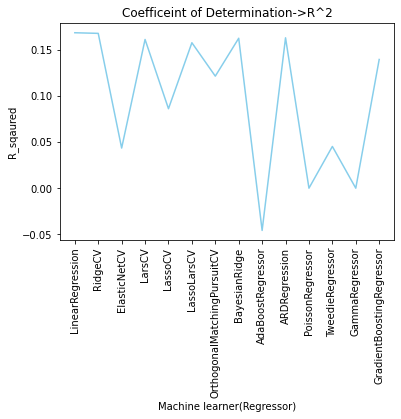

In [36]:
plt.plot( 'name', 'training_r2', data=results , color='skyblue')
plt.xticks(rotation='vertical')
plt.xlabel("Machine learner(Regressor)")
plt.ylabel("R_sqaured")
plt.title("Coefficeint of Determination->R^2")

Training MSE visualisation

Text(0.5, 1.0, 'Mean Squared Error(MSE) for training dataset')

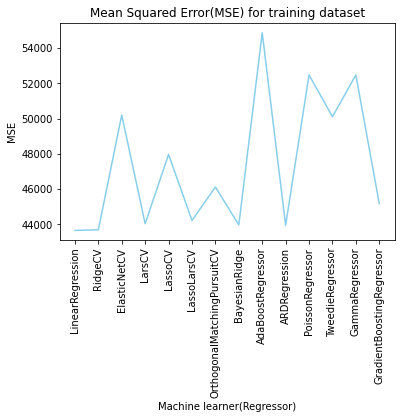

In [37]:
plt.plot( 'name', 'training_mse', data=results, color='skyblue')
plt.xticks(rotation='vertical')
plt.xlabel("Machine learner(Regressor)")
plt.ylabel("MSE")
plt.title("Mean Squared Error(MSE) for training dataset")

Text(0.5, 1.0, 'Mean Absoulte Error(MAE) for training dataset')

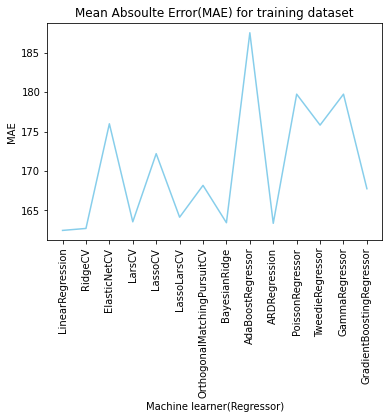

In [38]:
plt.plot( 'name', 'training_mae', data=results, color='skyblue')
plt.xticks(rotation='vertical')
plt.xlabel("Machine learner(Regressor)")
plt.ylabel("MAE")
plt.title("Mean Absoulte Error(MAE) for training dataset")

Testing MSE 

Text(0.5, 1.0, 'Mean squared error(MSE) for testing dataset')

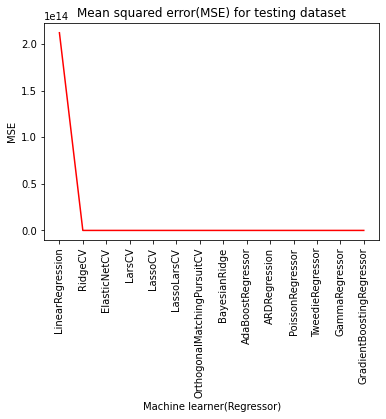

In [39]:
plt.plot( results['name'], results['testing_mse'], color='red')
plt.xticks(rotation='vertical')
plt.xlabel("Machine learner(Regressor)")
plt.ylabel("MSE")
plt.title("Mean squared error(MSE) for testing dataset")

Text(0.5, 1.0, 'Mean squared error(MSE) for testing dataset (Linear Regression dropped)')

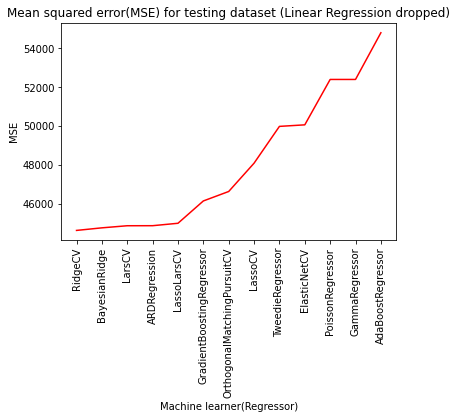

In [40]:
plt.plot( 'name', 'testing_mse', data=results.nsmallest(13, "testing_mse"), color='red')
plt.xticks(rotation='vertical')
plt.xlabel("Machine learner(Regressor)")
plt.ylabel("MSE")
plt.title("Mean squared error(MSE) for testing dataset (Linear Regression dropped)")

### Testing MAE

Text(0.5, 1.0, 'Mean absolute error(MAE) for testing data')

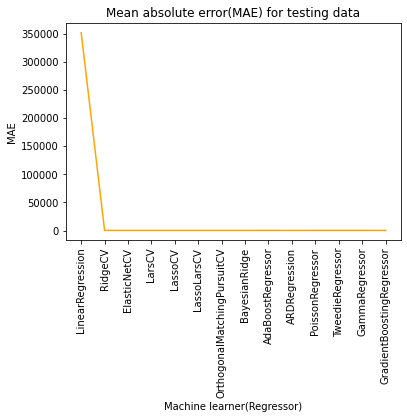

In [46]:
plt.plot( 'name', 'testing_mae', data=results, color='orange')
plt.xticks(rotation='vertical')
plt.xlabel("Machine learner(Regressor)")
plt.ylabel("MAE")
plt.title("Mean absolute error(MAE) for testing dataset")

Text(0.5, 1.0, 'Mean absolute error(MAE) for testing dataset (Linear Regression dropped)')

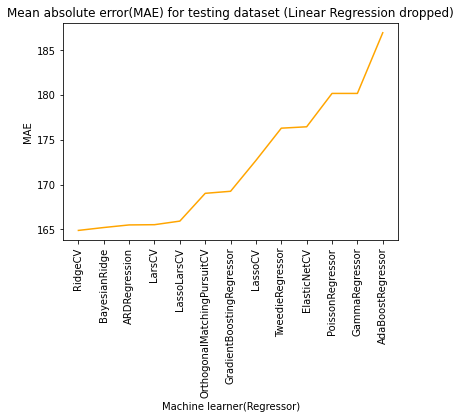

In [82]:
plt.plot( 'name', 'testing_mae', data=results.nsmallest(13, "testing_mae"), color='orange')
plt.xticks(rotation='vertical')
plt.xlabel("Machine learner(Regressor)")
plt.ylabel("MAE")
plt.title("Mean absolute error(MAE) for testing dataset (Linear Regression dropped)")

#### Hyperparameter $\alpha$ tuning 
https://scipy-lectures.org/packages/scikit-learn/auto_examples/plot_linear_model_cv.html

https://stackoverflow.com/questions/43374920/how-to-automatically-annotate-maximum-value-in-pyplot

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge, Lasso


alphas = np.logspace(-3, 1, 30)

scores = []
for Model in [Ridge]:
    scores = [cross_val_score(Model(alpha), train_bx, train_by, cv=10).mean()
            for alpha in alphas]
    plt.plot(alphas, scores, label=Model.__name__)

plt.legend(loc='lower left')
plt.xlabel('alpha')
plt.ylabel('cross validation r^2 score')
plt.title("Hyperparameter tuning- Cross validation score")

x = np.array(alphas)
y = np.array(scores)
xmax = x[np.argmax(y)]
ymax = y.max()
text= "x={:.3f}, y={:.3f}".format(xmax, ymax)
bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
kw = dict(xycoords='data',textcoords="axes fraction", arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
plt.annotate(text, xy=(xmax, ymax), xytext=(0.94,0.96), **kw)
plt.show()

## Ridge

In [108]:
from sklearn.linear_model import RidgeCV
rid = RidgeCV(alphas=np.arange(0.5, 3.5, 0.1).tolist(), store_cv_values=True)
rid.fit(train_bx, train_by)

RidgeCV(alphas=array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7,
       1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3. ,
       3.1, 3.2, 3.3, 3.4]),
        store_cv_values=True)

In [109]:
rid.alpha_

1.5999999999999996

In [73]:
len(train_bx)

29445

$R^2$

In [ ]:
rid.score(train_bx, train_by)

In [ ]:
coefs = pd.Series(rid.coef_, index = train_bx.columns)

#### Training scores

MSE

In [ ]:
print(format(mean_squared_error(train_by,rid.predict(train_bx)), '.8f'))

MAE

In [ ]:
mean_absolute_error(train_by, rid.predict(train_bx))

#### Test scores

MSE

In [ ]:
print(format(mean_squared_error(test_by, rid.predict(test_bx)), '.8f'))

MAE

In [ ]:
mean_absolute_error(test_by, rid.predict(test_bx))